In [174]:
import sys
import sqlite3

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [175]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

In [176]:
di = 'SPEI'
di_scale = 9

selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    'GPM_Precipitation',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM',
 ]

In [177]:
df = data.filter(items=selected_columns)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')

In [178]:
# selected_stations = ['Ramsar', 'Nowshahr']
selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
# selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

start_date = '2006-09'
end_date = '2023-10'

df = df.query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

In [179]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_9,GPM_Precipitation,PET_MOD16A2GF,NDVI,...,LSTDay,LSTNight,LST,PCI_GPM,VCI,TCI,VHI,CI_GPM,Year,Month
0,Siahbisheh,40735,36.231,51.303,1855.4,2007-05-01,1.691,37.944,213.362,0.542,...,27.31,6.51,16.910,0.252,0.402,0.691,0.547,0.448,2007,5
1,Siahbisheh,40735,36.231,51.303,1855.4,2007-06-01,1.741,41.040,248.950,0.539,...,32.34,10.81,21.575,0.812,0.283,0.532,0.408,0.542,2007,6
2,Siahbisheh,40735,36.231,51.303,1855.4,2007-07-01,1.744,31.992,244.712,0.501,...,29.80,10.91,20.355,0.400,0.360,1.000,0.680,0.587,2007,7
3,Siahbisheh,40735,36.231,51.303,1855.4,2007-08-01,1.516,12.648,237.262,0.438,...,33.11,12.19,22.650,0.122,0.382,0.708,0.545,0.404,2007,8
4,Siahbisheh,40735,36.231,51.303,1855.4,2007-09-01,1.263,35.280,181.925,0.422,...,34.12,10.01,22.065,0.507,0.584,0.256,0.420,0.449,2007,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,Alasht,99361,36.071,52.843,1805.0,2023-05-01,-2.021,34.224,201.938,0.469,...,30.68,11.31,20.995,0.441,0.000,0.141,0.070,0.194,2023,5
981,Alasht,99361,36.071,52.843,1805.0,2023-06-01,-1.852,29.520,247.350,0.461,...,29.42,13.02,21.220,0.462,0.236,0.836,0.536,0.511,2023,6
982,Alasht,99361,36.071,52.843,1805.0,2023-07-01,-1.998,15.624,259.525,0.466,...,31.65,14.71,23.180,0.215,0.573,0.767,0.670,0.518,2023,7
983,Alasht,99361,36.071,52.843,1805.0,2023-08-01,-2.033,20.088,239.275,0.420,...,34.26,14.97,24.615,0.222,0.537,0.274,0.406,0.345,2023,8


In [180]:
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')
df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_9,GPM_Precipitation,PET_MOD16A2GF,NDVI,...,LSTNight,LST,PCI_GPM,VCI,TCI,VHI,CI_GPM,Year,Month,SPEI_9_Class
0,Siahbisheh,40735,36.231,51.303,1855.4,2007-05-01,1.691,37.944,213.362,0.542,...,6.51,16.910,0.252,0.402,0.691,0.547,0.448,2007,5,VW
1,Siahbisheh,40735,36.231,51.303,1855.4,2007-06-01,1.741,41.040,248.950,0.539,...,10.81,21.575,0.812,0.283,0.532,0.408,0.542,2007,6,VW
2,Siahbisheh,40735,36.231,51.303,1855.4,2007-07-01,1.744,31.992,244.712,0.501,...,10.91,20.355,0.400,0.360,1.000,0.680,0.587,2007,7,VW
3,Siahbisheh,40735,36.231,51.303,1855.4,2007-08-01,1.516,12.648,237.262,0.438,...,12.19,22.650,0.122,0.382,0.708,0.545,0.404,2007,8,VW
4,Siahbisheh,40735,36.231,51.303,1855.4,2007-09-01,1.263,35.280,181.925,0.422,...,10.01,22.065,0.507,0.584,0.256,0.420,0.449,2007,9,MW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,Alasht,99361,36.071,52.843,1805.0,2023-05-01,-2.021,34.224,201.938,0.469,...,11.31,20.995,0.441,0.000,0.141,0.070,0.194,2023,5,ED
981,Alasht,99361,36.071,52.843,1805.0,2023-06-01,-1.852,29.520,247.350,0.461,...,13.02,21.220,0.462,0.236,0.836,0.536,0.511,2023,6,SD
982,Alasht,99361,36.071,52.843,1805.0,2023-07-01,-1.998,15.624,259.525,0.466,...,14.71,23.180,0.215,0.573,0.767,0.670,0.518,2023,7,SD
983,Alasht,99361,36.071,52.843,1805.0,2023-08-01,-2.033,20.088,239.275,0.420,...,14.97,24.615,0.222,0.537,0.274,0.406,0.345,2023,8,ED


In [181]:
cols_to_lag = ['GPM_Precipitation', 'PET_MOD16A2GF', 'NDVI', 'EVI', 'VHI', 'LST', 'PCI_GPM', 'TCI', 'VHI', 'CI_GPM']
for lag in range(1, 4):
    for col in cols_to_lag:
        # Important: Group by Station_ID to prevent data leakage across stations
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)

df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_9,GPM_Precipitation,PET_MOD16A2GF,NDVI,...,CI_GPM_lag_2,GPM_Precipitation_lag_3,PET_MOD16A2GF_lag_3,NDVI_lag_3,EVI_lag_3,VHI_lag_3,LST_lag_3,PCI_GPM_lag_3,TCI_lag_3,CI_GPM_lag_3
0,Siahbisheh,40735,36.231,51.303,1855.4,2007-05-01,1.691,37.944,213.362,0.542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Siahbisheh,40735,36.231,51.303,1855.4,2007-06-01,1.741,41.040,248.950,0.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Siahbisheh,40735,36.231,51.303,1855.4,2007-07-01,1.744,31.992,244.712,0.501,...,0.448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Siahbisheh,40735,36.231,51.303,1855.4,2007-08-01,1.516,12.648,237.262,0.438,...,0.542,37.944,213.362,0.542,0.303,0.547,16.910,0.252,0.691,0.448
4,Siahbisheh,40735,36.231,51.303,1855.4,2007-09-01,1.263,35.280,181.925,0.422,...,0.587,41.040,248.950,0.539,0.381,0.408,21.575,0.812,0.532,0.542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,Alasht,99361,36.071,52.843,1805.0,2023-05-01,-2.021,34.224,201.938,0.469,...,0.116,55.776,105.225,0.252,0.117,0.479,4.975,0.401,0.447,0.453
981,Alasht,99361,36.071,52.843,1805.0,2023-06-01,-1.852,29.520,247.350,0.461,...,0.200,45.384,142.175,0.291,0.134,0.043,12.915,0.264,0.000,0.116
982,Alasht,99361,36.071,52.843,1805.0,2023-07-01,-1.998,15.624,259.525,0.466,...,0.194,23.760,178.512,0.459,0.252,0.210,17.015,0.180,0.012,0.200
983,Alasht,99361,36.071,52.843,1805.0,2023-08-01,-2.033,20.088,239.275,0.420,...,0.511,34.224,201.938,0.469,0.287,0.070,20.995,0.441,0.141,0.194


In [182]:
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

# X = df.drop(
#     columns=[
#         'Station_Name',
#         'Station_ID',
#         'Date',
#         'Year',
#         f'{di}_{di_scale}',
#         f'{di}_{di_scale}_Class',
#     ]
# )

# y = df[f'{di}_{di_scale}']


df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y = df[f'{di}_{di_scale}_Class']

In [183]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=X['Month'] # Stratify by the 'Month' column
# )

# print("\n--- Data Shapes ---")
# print(f"Training features shape: {X_train.shape}")
# print(f"Testing features shape:  {X_test.shape}")

# # --- 4. Hyperparameter Tuning with XGBoost ---
# print("\n--- Starting Hyperparameter Tuning for XGBoost ---")
# # Define the parameter grid to search
# param_grid = {
#     'n_estimators': [100, 300, 500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7, 9],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'gamma': [0, 0.1, 0.2]
# }

# # Initialize the XGBoost regressor with categorical feature support enabled
# xgb_reg = xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     n_jobs=-1, 
#     random_state=42, 
#     enable_categorical=True  # <-- FIX: Enable support for categorical features
# )

# # Using a standard 5-fold cross-validation since the split is now random
# random_search = RandomizedSearchCV(
#     estimator=xgb_reg,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     cv=5, 
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# best_model = random_search.best_estimator_

# # --- 6. Prediction and Evaluation ---
# y_pred = best_model.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (XGBoost with Stratified Split) ---")
# print(f"R-squared (R²): {r2:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# plt.figure(figsize=(12, 10))
# xgb.plot_importance(best_model, importance_type='weight', ax=plt.gca(), max_num_features=20)
# plt.title('Top 20 Feature Importances for SPI-3 Prediction (XGBoost)', fontsize=16)
# plt.xlabel('Weight (Frequency of Use in Trees)', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Actual vs. Predicted Scatter Plot
# plt.figure(figsize=(8, 8))
# plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', c='royalblue')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
# plt.title('Actual vs. Predicted SPI-3 (Optimized XGBoost)', fontsize=16)
# plt.xlabel('Actual SPI-3', fontsize=12)
# plt.ylabel('Predicted SPI-3', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.axis('equal')
# plt.show()

In [184]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=X['Month']
# )

# print("\n--- Data Shapes ---")
# print(f"Training features shape: {X_train.shape}")
# print(f"Testing features shape:  {X_test.shape}")

# # --- 4. Hyperparameter Tuning with Random Forest ---
# print("\n--- Starting Hyperparameter Tuning for Random Forest ---")
# # Define the parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 1.0]
# }

# # Initialize the Random Forest regressor
# rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=rf_reg,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# best_model = random_search.best_estimator_

# # --- 6. Prediction and Evaluation ---
# y_pred = best_model.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (Random Forest with Stratified Split) ---")
# print(f"R-squared (R²): {r2:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# plt.figure(figsize=(12, 10))
# sns.barplot(x=feature_importances.head(20), y=feature_importances.head(20).index)
# plt.title('Top 20 Feature Importances for SPI-3 Prediction (Random Forest)', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Actual vs. Predicted Scatter Plot
# plt.figure(figsize=(8, 8))
# plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', c='seagreen')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
# plt.title('Actual vs. Predicted SPI-3 (Optimized Random Forest)', fontsize=16)
# plt.xlabel('Actual SPI-3', fontsize=12)
# plt.ylabel('Predicted SPI-3', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.axis('equal')
# plt.show()

In [185]:
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV, train_test_split
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LassoCV
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- 3a. Stratified Random Split based on Month ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=X['Month']
# )

# # --- 3b. Automatic Feature Selection using LassoCV ---
# print("\n--- Performing Feature Selection with LassoCV ---")
# # Lasso is sensitive to feature scaling, so we scale the data first
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Use LassoCV to find the best alpha and fit the model
# lasso = LassoCV(cv=5, random_state=42, n_jobs=-1).fit(X_train_scaled, y_train)

# # Get the absolute value of the coefficients to determine importance
# importance = np.abs(lasso.coef_)

# # Select the top N features based on the largest coefficients
# # You can change this number to 5, 6, or any other value.
# num_features_to_select = 6
# top_feature_indices = np.argsort(importance)[-num_features_to_select:]
# selected_features = X_train.columns[top_feature_indices]

# print(f"Selected top {num_features_to_select} features out of {X_train.shape[1]}")
# print("Selected features:", list(selected_features))

# # Create new dataframes with only the selected features
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]


# print("\n--- Data Shapes After Feature Selection ---")
# print(f"Training features shape: {X_train_selected.shape}")
# print(f"Testing features shape:  {X_test_selected.shape}")

# # --- 4. Hyperparameter Tuning with Random Forest ---
# print("\n--- Starting Hyperparameter Tuning on Selected Features ---")
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 1.0]
# }

# rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

# random_search = RandomizedSearchCV(
#     estimator=rf_reg,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit the search on the data with selected features
# random_search.fit(X_train_selected, y_train)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# best_model = random_search.best_estimator_

# # --- 6. Prediction and Evaluation ---
# y_pred = best_model.predict(X_test_selected)

# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (Random Forest with Lasso Selection) ---")
# print(f"R-squared (R²): {r2:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)

# plt.figure(figsize=(12, 10))
# sns.barplot(x=feature_importances, y=feature_importances.index)
# plt.title(f'Feature Importances for Top {num_features_to_select} Features (Random Forest)', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Actual vs. Predicted Scatter Plot
# plt.figure(figsize=(8, 8))
# plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', c='seagreen')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
# plt.title('Actual vs. Predicted SPI-3 (Optimized Random Forest)', fontsize=16)
# plt.xlabel('Actual SPI-3', fontsize=12)
# plt.ylabel('Predicted SPI-3', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.axis('equal')
# plt.show()



--- Performing Feature Selection ---
Selected top 8 features out of 43
Selected features: ['CI_GPM_lag_3', 'PCI_GPM_lag_1', 'CI_GPM', 'VCI', 'CI_GPM_lag_1', 'CI_GPM_lag_2', 'VHI_lag_1', 'VHI_lag_2']

--- Data Shapes After Feature Selection ---
Training features shape: (776, 8)
Testing features shape:  (194, 8)

--- Starting Hyperparameter Tuning on Selected Features ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Hyperparameters found:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 10, 'class_weight': None}

--- Training Final Model with Optimal Parameters ---

--- Final Model Evaluation Metrics (Random Forest Classifier) ---
Accuracy: 0.6392

Classification Report:
              precision    recall  f1-score   support

          ED       0.00      0.00      0.00         5
          EW       0.00      0.00      0.00         2
          MD       0.12      0.06      0.08        17
          MW       0.25   

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

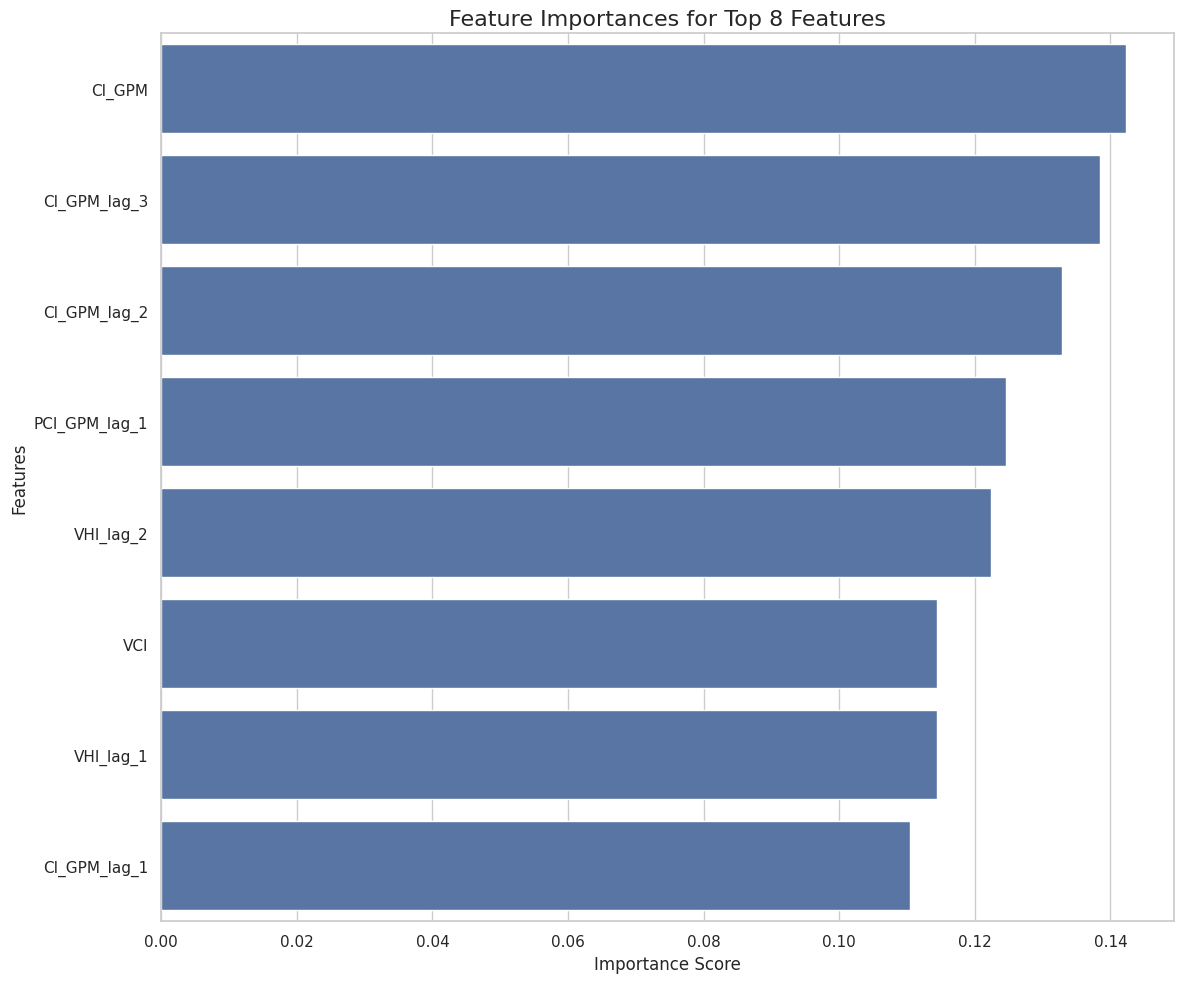

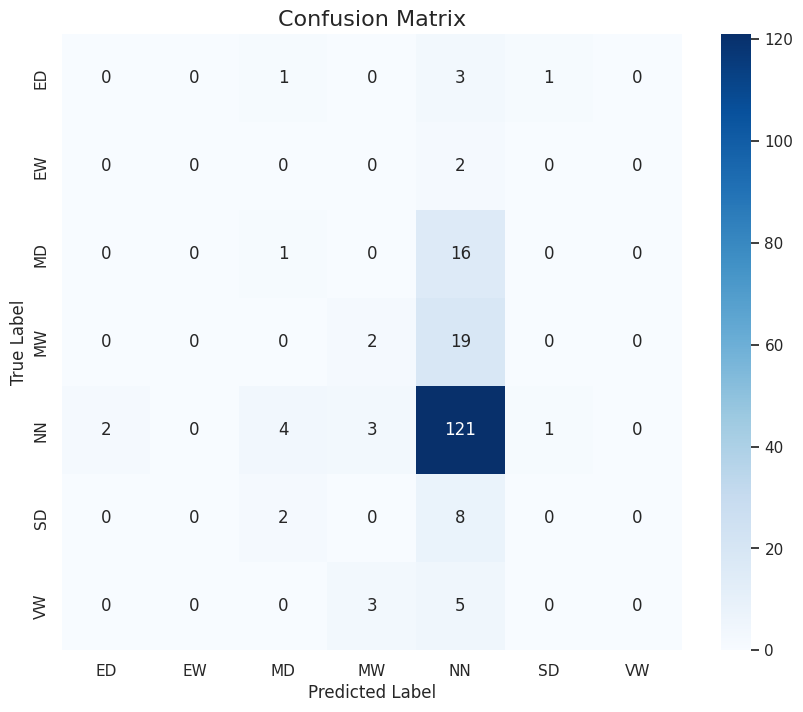

In [186]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# --- 3a. Stratified Random Split based on Target Class ---
# We stratify by 'y' to ensure each class is proportionally represented
# in both the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# --- 3b. Automatic Feature Selection using RandomForestClassifier ---
print("\n--- Performing Feature Selection ---")
# Train a preliminary classifier to get feature importances
fs_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
fs_model.fit(X_train, y_train)

# Get feature importances
importance = fs_model.feature_importances_

# Select the top N features
num_features_to_select = 8
top_feature_indices = np.argsort(importance)[-num_features_to_select:]
selected_features = X_train.columns[top_feature_indices]

print(f"Selected top {num_features_to_select} features out of {X_train.shape[1]}")
print("Selected features:", list(selected_features))

# Create new dataframes with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("\n--- Data Shapes After Feature Selection ---")
print(f"Training features shape: {X_train_selected.shape}")
print(f"Testing features shape:  {X_test_selected.shape}")

# --- 4. Hyperparameter Tuning with Random Forest Classifier ---
print("\n--- Starting Hyperparameter Tuning on Selected Features ---")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 1.0],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy', # Use a classification metric
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_selected, y_train)
print("\nBest Hyperparameters found: ", random_search.best_params_)

# --- 5. Optimized Model Training ---
print("\n--- Training Final Model with Optimal Parameters ---")
best_model = random_search.best_estimator_

# --- 6. Prediction and Evaluation ---
y_pred = best_model.predict(X_test_selected)

# Use classification metrics for evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n--- Final Model Evaluation Metrics (Random Forest Classifier) ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# --- 7. Visualization for Thesis ---
sns.set_theme(style="whitegrid")

# a) Feature Importance Plot
feature_importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title(f'Feature Importances for Top {num_features_to_select} Features', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# b) Confusion Matrix
# This plot shows how the model performed on each class.
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
